In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def normalize_string_column_values(df, column_name):
    df[column_name] = df[column_name].str.upper()
    df[column_name] = df[column_name].str.strip()
    df[column_name] = df[column_name].fillna("UNDEFINED")
    return df

In [2]:
inventory = pd.read_csv('data/inventory_logs.csv')
inventory = inventory.drop(columns=['Unnamed: 0'])
products = pd.read_csv('data/products.csv')
products = products.drop(columns=['created_at', 'Unnamed: 0'])
categories = pd.read_csv('data/categories.csv')
categories = categories.drop(columns=['created_at', 'Unnamed: 0'])

#### Limpieza y creación de columnas útiles

In [25]:
normalize_string_column_values(inventory, 'movement_type')
normalize_string_column_values(inventory, 'reason')
normalize_string_column_values(products, 'product_name')
normalize_string_column_values(products, 'brand')
normalize_string_column_values(categories, 'category_name')
normalize_string_column_values(categories, 'parent_category')
inventory = inventory.merge(products[["product_id", "product_name", "category_id"]], on="product_id", how="left")
inventory = inventory.merge(categories, on="category_id", how="left")
inventory["timestamp"] = pd.to_datetime(inventory["timestamp"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce")
inventory["date"] = pd.DatetimeIndex(inventory["timestamp"]).date
inventory["year_month"] = pd.DatetimeIndex(inventory["timestamp"]).strftime('%Y-%m')

#### En el tiempo

In [ ]:
inventory["change_sign"] = -1
inventory.loc[inventory["quantity_change"].notnull() & (inventory["quantity_change"] > 0), "change_sign"] = 1
inventory.loc[inventory["quantity_change"].notnull() & (inventory["quantity_change"] < 0), "change_sign"] = 0

inventory.groupby("reason")["change_sign"].nunique()

reason
ADJUSTMENT    3
DAMAGE        3
PURCHASE      3
RETURN        3
SALE          3
THEFT         3
TRANSFER      3
UNDEFINED     3
Name: change_sign, dtype: int64

Todas las reason tienen logs con entradas y salidas de productos (y valores nulos).<br>
Entonces, la columna "reason" es un poco ambigua.

¿Por qué hay registros de robos (theft) en las que hay valores positivos y negativos?<br>
¿Robaron cosas del inventario, pero también ingresaron cosas robadas al inventario?<br>

Ídem con los artículos dañados (damage)

In [5]:
inventory.loc[inventory["reason"] == "THEFT"].loc[inventory["change_sign"] == 1]

,log_id,product_id,movement_type,quantity_change,reason,timestamp,reference_id,notes,date,year_month,change_sign
43,44,928659,IN,68.0,THEFT,NaT,37967,NaN,NaT,NaN,1
53,54,985461,IN,62.0,THEFT,2023-11-13 08:28:21.745165,57991,NaN,2023-11-13,2023-11,1
75,76,996304,ADJUSTMENT,22.0,THEFT,NaT,52292,NaN,NaT,NaN,1
84,85,909756,IN,162.0,THEFT,2024-08-10 20:07:46.534858,21745,NaN,2024-08-10,2024-08,1
101,102,964717,IN,198.0,THEFT,2025-06-19 09:01:14.521633,70369,NaN,2025-06-19,2025-06,1
...,...,...,...,...,...,...,...,...,...,...,...
399907,399908,943715,IN,77.0,THEFT,2024-09-14 14:09:57.453519,14593,Recognize future must exist near they.,2024-09-14,2024-09,1
399913,399914,927735,IN,190.0,THEFT,NaT,32465,NaN,NaT,NaN,1
399951,399952,951828,ADJUSTMENT,39.0,THEFT,2024-12-02 12:03:41.499878,14269,NaN,2024-12-02,2024-12,1
399981,399982,928460,ADJUSTMENT,43.0,THEFT,2025-05-11 16:22:04.027057,60585,Treatment test scene need fire wife.,2025-05-11,2025-05,1


In [6]:
inventory.loc[inventory["reason"] == "THEFT"].loc[inventory["change_sign"] == 0]

,log_id,product_id,movement_type,quantity_change,reason,timestamp,reference_id,notes,date,year_month,change_sign
13,14,921138,OUT,-282.0,THEFT,2024-04-30 03:39:12.004992,93729,NaN,2024-04-30,2024-04,0
18,19,974192,ADJUSTMENT,-62.0,THEFT,2025-01-12 19:41:20.210084,43918,Very finally general by admit.,2025-01-12,2025-01,0
34,35,909385,OUT,-386.0,THEFT,2024-04-29 21:47:11.414068,64257,NaN,2024-04-29,2024-04,0
52,53,971532,OUT,-328.0,THEFT,2023-11-24 19:56:23.723549,71618,NaN,2023-11-24,2023-11,0
59,60,902424,OUT,-203.0,THEFT,2025-05-02 17:15:57.757704,74879,NaN,2025-05-02,2025-05,0
...,...,...,...,...,...,...,...,...,...,...,...
399925,399926,977196,OUT,-220.0,THEFT,2024-05-10 15:45:52.779155,30024,NaN,2024-05-10,2024-05,0
399956,399957,963768,ADJUSTMENT,-78.0,THEFT,2024-05-20 23:50:51.504696,69318,NaN,2024-05-20,2024-05,0
399962,399963,957037,ADJUSTMENT,-15.0,THEFT,2023-09-30 14:14:26.998316,60935,Expect scientist wait head order imagine bill.,2023-09-30,2023-09,0
399978,399979,975102,OUT,-320.0,THEFT,2025-01-14 13:02:47.128830,88437,NaN,2025-01-14,2025-01,0


Cantidad de movimientos de salida por día

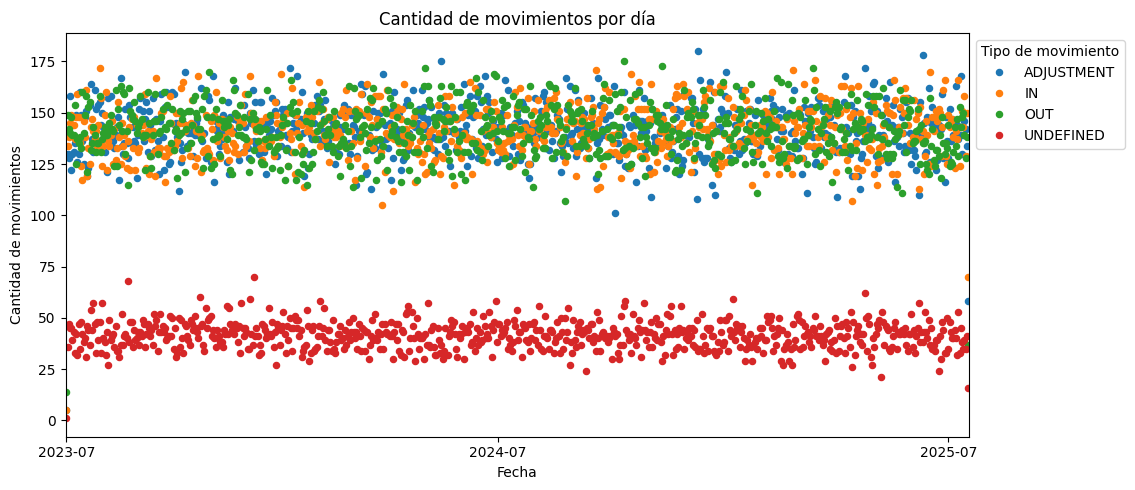

In [7]:
plt.figure(figsize=(10, 5))
data = inventory.groupby(["movement_type", "date"], as_index=False)["log_id"].count()
for move in data["movement_type"].unique():    
    sns.pointplot(
        data.loc[data["movement_type"] == move],
        x="date", y="log_id", label=move, linestyles='', markers='.'
    )
plt.xlabel("Fecha")
plt.ylabel("Cantidad de movimientos")
plt.title("Cantidad de movimientos por día")
plt.xticks(ticks=["2023-07-17", "2024-07-01", "2025-07-01"], labels=["2023-07", "2024-07", "2025-07"])
plt.tight_layout()
plt.legend(title="Tipo de movimiento", bbox_to_anchor=(1, 1), loc='upper left')

<Figure size 1000x500 with 0 Axes>

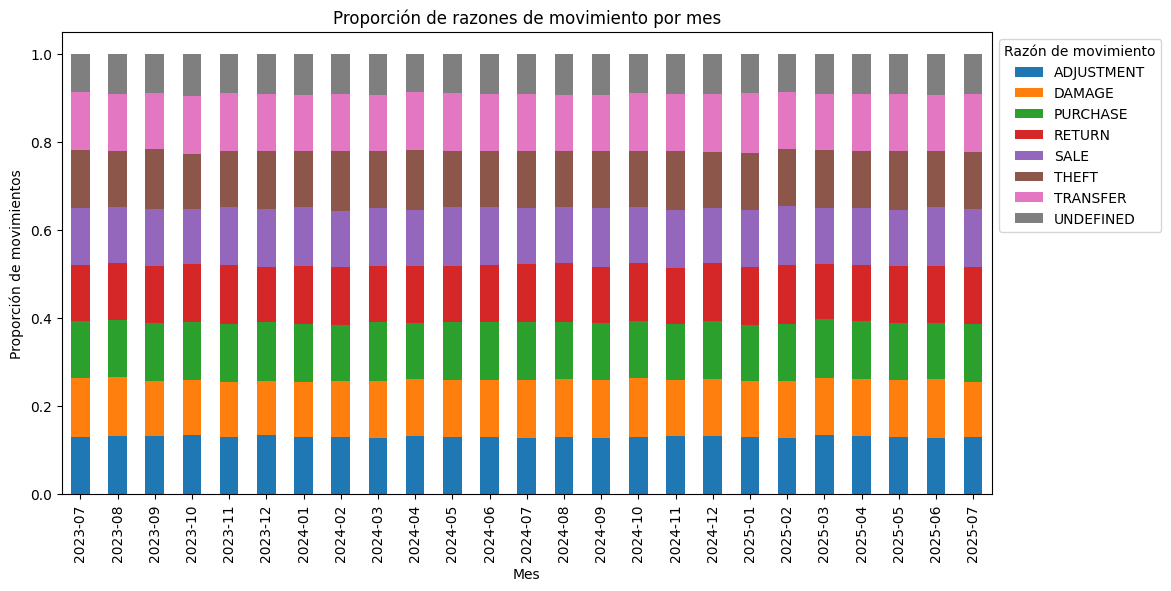

In [8]:
# tipo de movimiento por mes
plt.figure(figsize=(10, 5))
data = inventory.groupby(["year_month", "reason"])["log_id"].count().unstack()
data.div(data.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Mes")
plt.ylabel("Proporción de movimientos")
plt.title("Proporción de razones de movimiento por mes")
plt.legend(title="Razón de movimiento", bbox_to_anchor=(1, 1), loc='upper left')

<Figure size 1000x500 with 0 Axes>

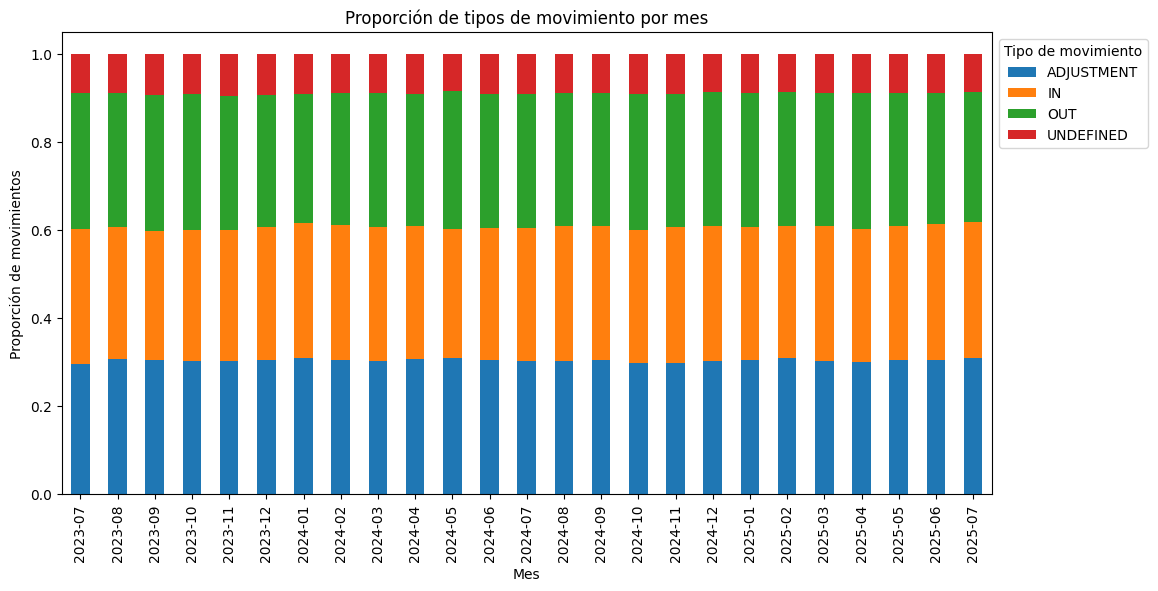

In [9]:
# tipo de movimiento por mes
plt.figure(figsize=(10, 5))
data = inventory.groupby(["year_month", "movement_type"])["log_id"].count().unstack()
data.div(data.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Mes")
plt.ylabel("Proporción de movimientos")
plt.title("Proporción de tipos de movimiento por mes")
plt.legend(title="Tipo de movimiento", bbox_to_anchor=(1, 1), loc='upper left')

In [10]:

data = inventory.groupby(["year_month", "movement_type"])["quantity_change"].sum().unstack()
data["total"] = data.sum(axis=1)
data

movement_type,ADJUSTMENT,IN,OUT,UNDEFINED,total
year_month,,,,,
2023-07,-4249.0,418276.0,-424061.0,-1721.0,-11755.0
2023-08,2931.0,922896.0,-940026.0,208.0,-13991.0
2023-09,1313.0,867833.0,-912546.0,2042.0,-41358.0
2023-10,-1802.0,916200.0,-954100.0,1124.0,-38578.0
2023-11,2803.0,872490.0,-915009.0,6595.0,-33121.0
2023-12,-2117.0,956131.0,-921999.0,-10881.0,21134.0
2024-01,-3006.0,924410.0,-904200.0,4226.0,21430.0
2024-02,4730.0,888772.0,-869745.0,7865.0,31622.0
2024-03,-18.0,942442.0,-926318.0,-1601.0,14505.0


<Figure size 1000x500 with 0 Axes>

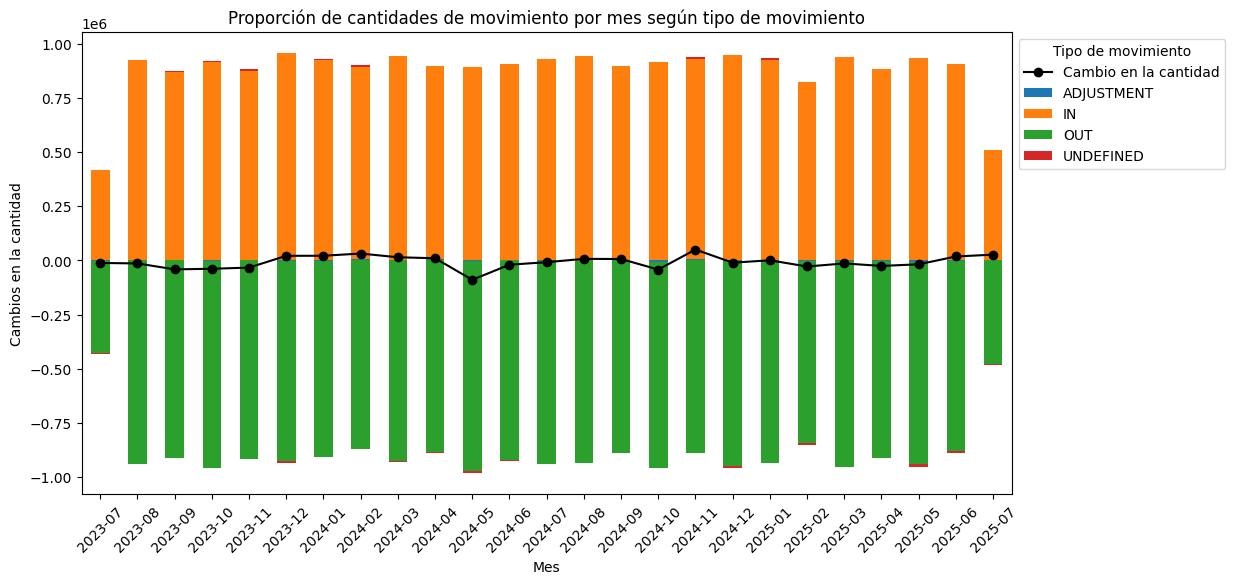

In [11]:
# tipo de movimiento por mes
plt.figure(figsize=(10, 5))
data = inventory.groupby(["year_month", "movement_type"])["quantity_change"].sum().unstack()
data.plot(kind='bar', stacked=True, figsize=(12,6))
data["total"] = data.sum(axis=1)
data["total"].plot(marker='o', color='black', label='Cambio en la cantidad', legend=True)
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Cambios en la cantidad")
plt.title("Proporción de cantidades de movimiento por mes según tipo de movimiento")
plt.legend(title="Tipo de movimiento", bbox_to_anchor=(1, 1), loc='upper left')

Las cantidades de totales en el inventario sin distinguir entre productos (linea negra) se mantienen más o menos constantes.<br>
Los tipos de movimientos que pueden tanto aumentar como reducir la cantidad (ADJUSTEMENT y UNDEFINED), tienen totales por mes muy pequeños.<br>
En cambio, los que sólo pueden aumentar o reducir la cantidad (IN y OUT) se contrarestan entre sí.

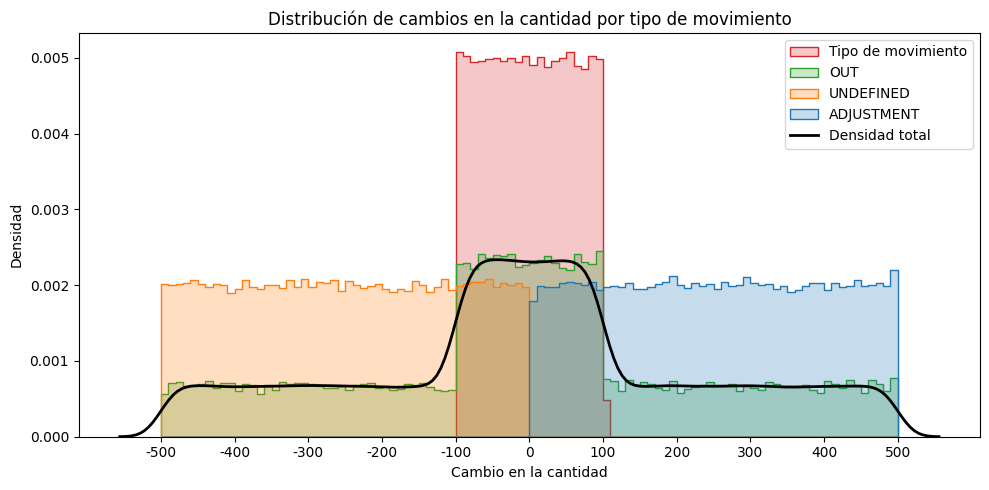

In [13]:
plt.figure(figsize=[10, 5])
# histograma de cambios en la cantidad por tipo de movimiento
sns.histplot(
    data=inventory.rename(columns={"movement_type": "Tipo de movimiento", "quantity_change": "Cambio en la cantidad"}),
    x="Cambio en la cantidad",
    hue="Tipo de movimiento",
    bins=100,
    stat="density",
    common_norm=False,             # no normalizar entre las categorías
    element="step"                 # sin lineas rellenas
)
# funcion de densidad de probabilidad total
sns.kdeplot(
    data=inventory,
    x="quantity_change",
    color="black",
    linewidth=2,
)
plt.ylabel("Densidad")
plt.title("Distribución de cambios en la cantidad por tipo de movimiento")
xticks = list(range(-500, 501, 100))
plt.xticks(ticks=xticks, labels=xticks)
legend_labels = plt.gca().get_legend().get_texts()
legend_labels[0].set_text("Tipo de movimiento")
legend_labels.append(plt.Text(0, 0, "Densidad total", color="black"))
plt.legend(labels=[text.get_text() for text in legend_labels])
plt.tight_layout()

Notar que aún con 100 bins, el histograma muestra probabilidades prácticamente uniformes para los valores de cambio en la cantidad.<br>
Además de que los valores se mueven exactamente en los rangos [-500, 0], [-100, 100] y [0, 500].<br>
El unico tipo de movimiento que posee probabilidad no uniforme es UNDEFINED, que sigue la misma distribución que la densidad total.

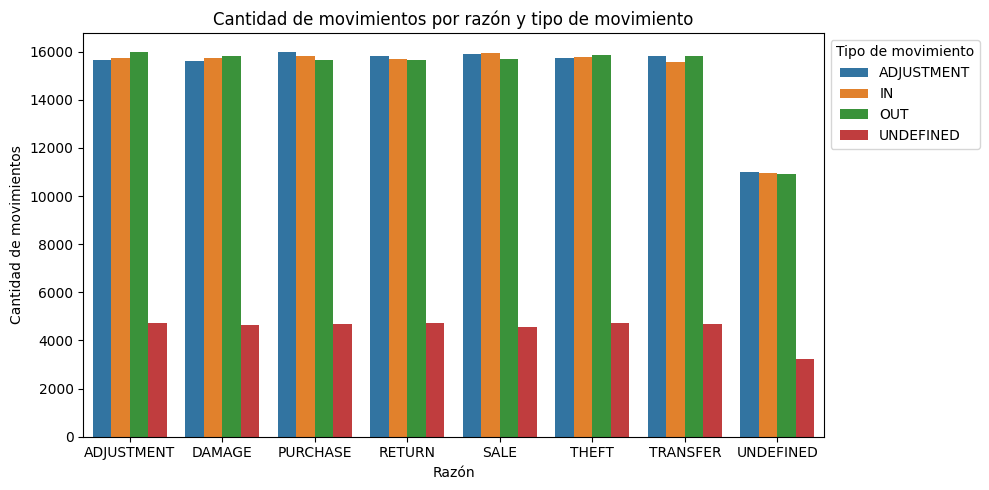

In [14]:
plt.figure(figsize=[10, 5])
sns.barplot(
    data=inventory.groupby(["reason", "movement_type"])["log_id"].count().reset_index(),
    x="reason", y="log_id", hue="movement_type"
)
plt.xlabel("Razón")
plt.ylabel("Cantidad de movimientos")
plt.title("Cantidad de movimientos por razón y tipo de movimiento")
plt.legend(title="Tipo de movimiento", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

In [15]:
inventory.loc[inventory["reason"] != "UNDEFINED"]\
        .loc[inventory["movement_type"] != "UNDEFINED"]\
        .groupby(["reason", "movement_type"])["log_id"].count().describe()

count       21.000000
mean     15771.285714
std        116.252803
min      15559.000000
25%      15702.000000
50%      15773.000000
75%      15827.000000
max      15983.000000
Name: log_id, dtype: float64

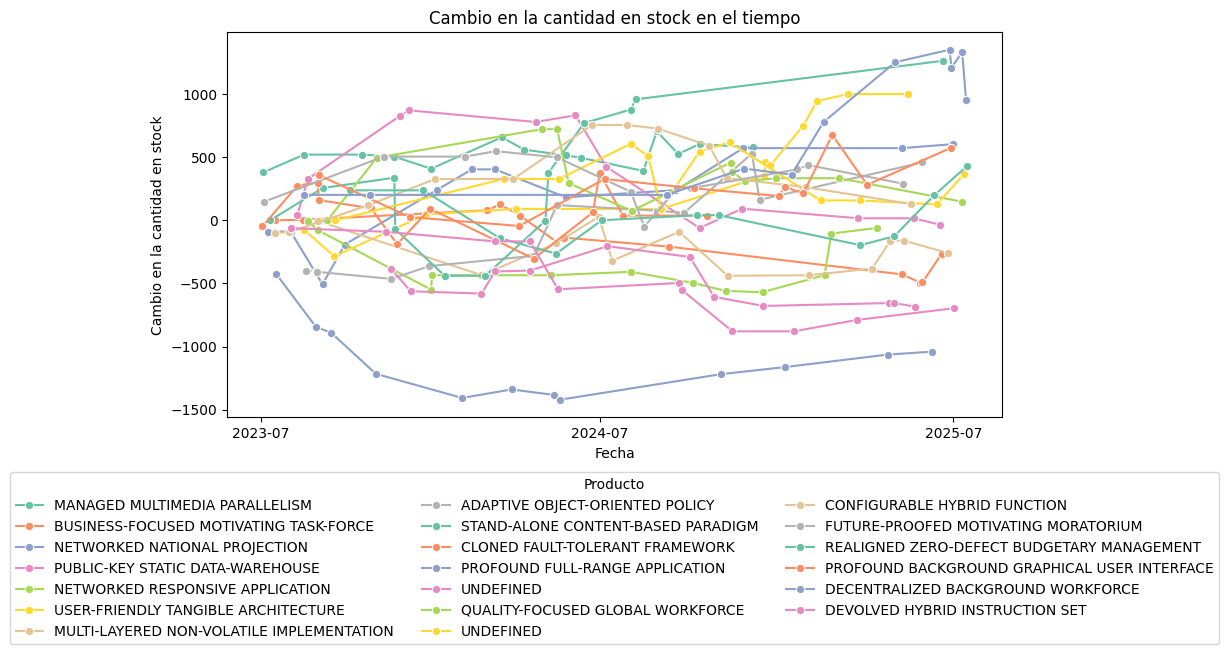

In [16]:
# Calculo la variacion de cantidad por producto y fecha
data = inventory.groupby(["product_id", "date"], as_index=False).quantity_change.sum()
# Me quedo con los 3 productos con mas movimientos
top_products = data["product_id"].value_counts().nlargest(20).reset_index()
data = data.loc[data["product_id"].isin(top_products["product_id"])]

# Calculo la suma acumulada de la variacion de cantidad por producto
data["cumsum"] = data.groupby("product_id")["quantity_change"].cumsum()

data = data.reset_index()
data["quantity_change"] = data["quantity_change"].fillna(0)

top_products = top_products.merge(products[["product_id", "product_name"]], on="product_id", how="left")[["product_id", "product_name"]]
plt.figure(figsize=(10, 5))
colors = sns.color_palette("Set2", n_colors=len(top_products))
for (i, (pid, pn)) in enumerate(top_products.values.tolist()):
    sns.lineplot(
        data.loc[data["product_id"] == pid],
        x="date", y="cumsum", linestyle='-', marker='o', color=colors[i], label=pn
    )
    plt.xticks(ticks=["2023-07-17", "2024-07-01", "2025-07-01"], labels=["2023-07", "2024-07", "2025-07"])
    plt.legend(title="Producto", bbox_to_anchor=(0.5, -0.125), loc='upper center', ncol=3)
    plt.xlabel("Fecha")
    plt.ylabel("Cambio en la cantidad en stock")
    plt.title("Cambio en la cantidad en stock en el tiempo")

In [23]:
# top 5 productos más robados
stolen = inventory.loc[inventory["reason"] == "THEFT"].product_id.value_counts().reset_index()
stolen = stolen.merge(products[["product_id","product_name", "category_id"]], how="left")
stolen_category = stolen.groupby("category_id").agg({
    "product_id": "count",
    "count": "sum"
}).reset_index()
stolen_category = stolen_category.merge(categories[["category_id", "category_name", "parent_category"]], how="left")
stolen_parent_category = stolen_category.groupby("parent_category").agg({
    "product_id": "sum",
    "count": "sum"
}).reset_index()
stolen_category = stolen_category.rename(columns={
    "product_id": "distinct_products",
    "count": "stolen_units"
})
stolen_parent_category = stolen_parent_category.rename(columns={
    "product_id": "distinct_products",
    "count": "stolen_units"
})
stolen_parent_category

,parent_category,distinct_products,stolen_units
0,ART & CRAFTS,1161,1479
1,AUTOMOTIVE,1088,1422
2,BABY & KIDS,1103,1388
3,BOOKS,1196,1559
4,CLOTHING,877,1134
5,COLLECTIBLES,1362,1758
6,ELECTRONICS,887,1099
7,FOOD & BEVERAGES,872,1127
8,FURNITURE,1854,2353
9,GAMES & VIRTUAL GOODS,1380,1803


,distinct_products,stolen_units
count,31.000000,31.000000
mean,1310.129032,1680.516129
std,568.803993,726.351883
min,872.000000,1099.000000
25%,1107.000000,1418.000000
50%,1169.000000,1515.000000
75%,1373.500000,1773.500000
max,4142.000000,5296.000000


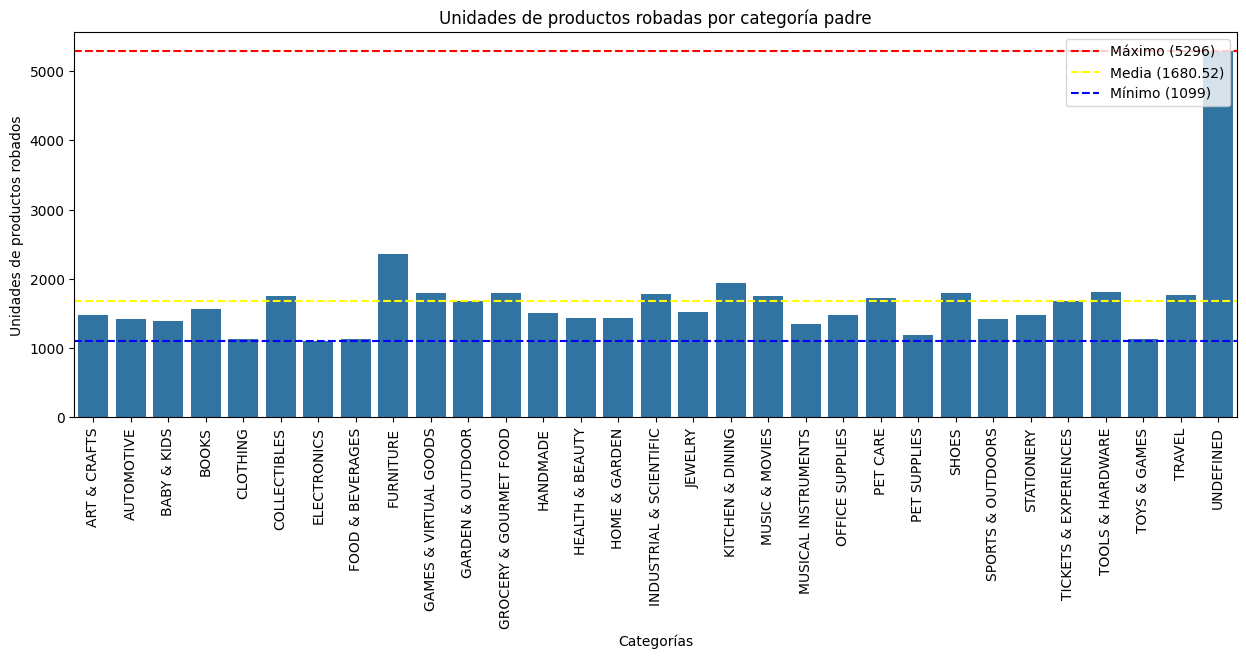

In [18]:
plt.figure(figsize=[15, 5])
sns.barplot(
    data=stolen_parent_category,
    x="parent_category", y="stolen_units"
)
plt.xticks(rotation=90, fontsize=10)
plt.xlabel("Categorías")
plt.ylabel("Unidades de productos robados")
plt.title("Unidades de productos robadas por categoría padre")

max_count = stolen_parent_category["stolen_units"].max()
avg_count = stolen_parent_category["stolen_units"].mean()
min_count = stolen_parent_category["stolen_units"].min()
plt.axhline(max_count, color='red', linestyle='--', label=f'Máximo ({max_count})')
plt.axhline(avg_count, color='yellow', linestyle='--', label=f'Media ({avg_count:.2f})')
plt.axhline(min_count, color='blue', linestyle='--', label=f'Mínimo ({min_count})')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
stolen_parent_category.describe()


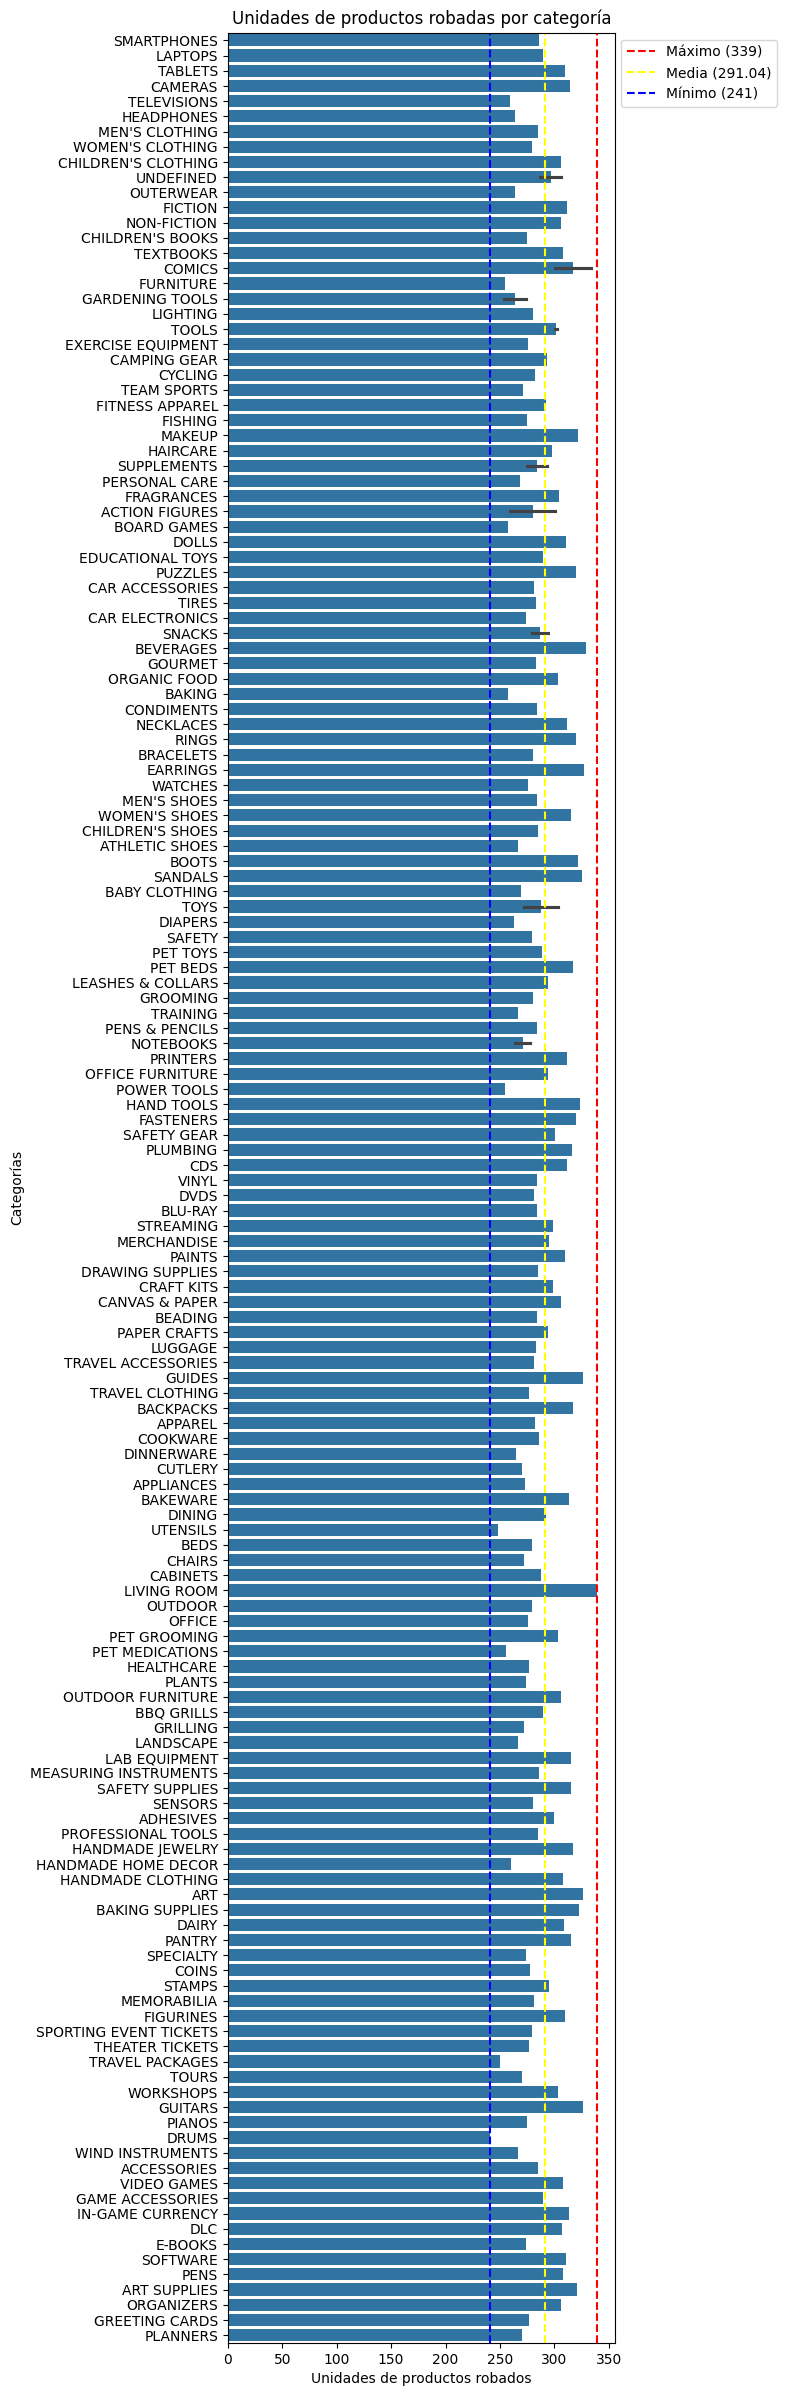

In [19]:
plt.figure(figsize=[5, 30])
sns.barplot(
    data=stolen_category,
    y="category_name", x="stolen_units"
)
plt.yticks(rotation=0, fontsize=10)
plt.ylabel("Categorías")
plt.xlabel("Unidades de productos robados")
plt.title("Unidades de productos robadas por categoría")

max_count = stolen_category["stolen_units"].max()
avg_count = stolen_category["stolen_units"].mean()
min_count = stolen_category["stolen_units"].min()
plt.axvline(max_count, color='red', linestyle='--', label=f'Máximo ({max_count})')
plt.axvline(avg_count, color='yellow', linestyle='--', label=f'Media ({avg_count:.2f})')
plt.axvline(min_count, color='blue', linestyle='--', label=f'Mínimo ({min_count})')
plt.legend(loc='upper right', bbox_to_anchor=(1.435, 1))

In [20]:
stolen_category.describe()

,category_id,distinct_products,stolen_units
count,179.000000,179.000000,179.000000
mean,90.000000,226.893855,291.039106
std,51.816986,14.573908,20.888512
min,1.000000,197.000000,241.000000
25%,45.500000,215.000000,276.500000
50%,90.000000,225.000000,288.000000
75%,134.500000,236.000000,308.000000
max,179.000000,257.000000,339.000000


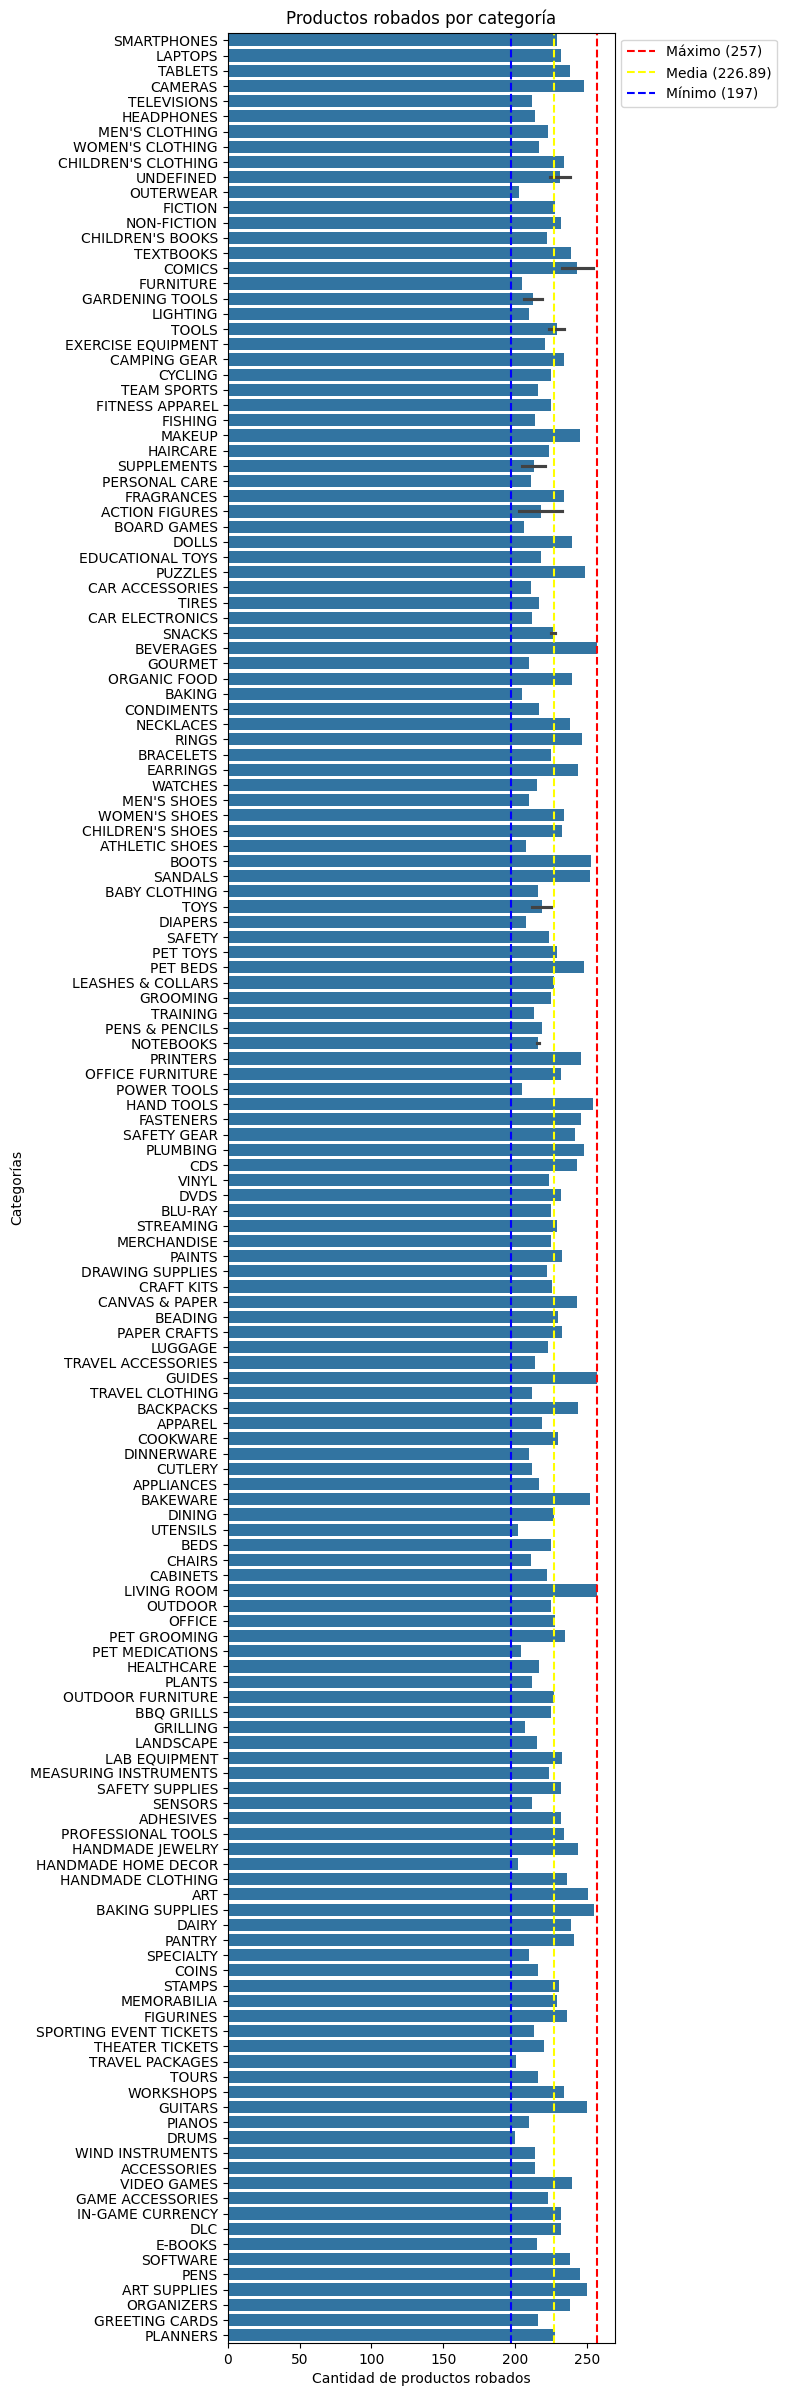

In [21]:
plt.figure(figsize=[5, 30])
sns.barplot(
    data=stolen_category,
    y="category_name", x="distinct_products"
)
plt.yticks(rotation=0, fontsize=10)
plt.ylabel("Categorías")
plt.xlabel("Cantidad de productos robados")
plt.title("Productos robados por categoría")

max_count = stolen_category["distinct_products"].max()
avg_count = stolen_category["distinct_products"].mean()
min_count = stolen_category["distinct_products"].min()
plt.axvline(max_count, color='red', linestyle='--', label=f'Máximo ({max_count})')
plt.axvline(avg_count, color='yellow', linestyle='--', label=f'Media ({avg_count:.2f})')
plt.axvline(min_count, color='blue', linestyle='--', label=f'Mínimo ({min_count})')
plt.legend(loc='upper right', bbox_to_anchor=(1.435, 1))

In [51]:
out_by_month = inventory.loc[inventory.movement_type == "OUT"]\
        .groupby(["year_month", "parent_category"])["quantity_change"].sum().reset_index()
out_by_month.loc[out_by_month.year_month == "2024-12"].nsmallest(5, columns="quantity_change")

,year_month,parent_category,quantity_change
557,2024-12,UNDEFINED,-95500.0
535,2024-12,FURNITURE,-46116.0
538,2024-12,GROCERY & GOURMET FOOD,-36256.0
554,2024-12,TOOLS & HARDWARE,-35458.0
544,2024-12,KITCHEN & DINING,-34424.0


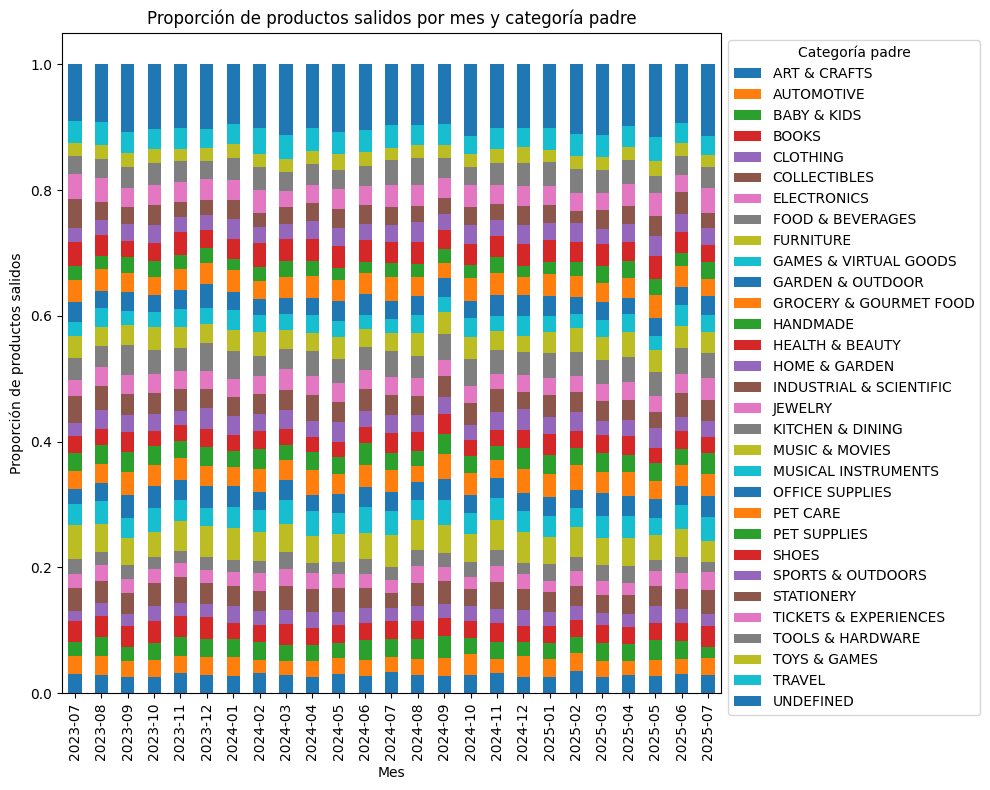

In [49]:
out_by_month = inventory.loc[inventory.movement_type == "OUT"]\
        .groupby(["year_month", "parent_category"])["quantity_change"].sum().unstack()
out_by_month_norm = out_by_month.div(out_by_month.sum(axis=1), axis=0)
out_by_month_norm.plot(kind='bar', stacked=True, figsize=(10, 8))
plt.xlabel("Mes")
plt.ylabel("Proporción de productos salidos")
plt.title("Proporción de productos salidos por mes y categoría padre")
plt.legend(title="Categoría padre", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()